# **Solving the 1D Heat Equation Using Physics-Informed Neural Networks (PINNs)**


This notebook demonstrates how to use a PINN (Physics-Informed Neural Network) to solve the 1D Heat Equation, a canonical partial differential equation (PDE) in mathematical physics.

## **Problem Statement**

We consider the 1D heat equation on the domain $x\in[0,1]$ and $t\in[0,1]$:

$$
\frac{\partial{u}}{\partial{t}} = \frac{\partial^2{u}}{\partial{t^2}}
$$

- Initial Condition:
$$ 
u(x, 0) = \sin(\pi x)
$$

- Boundary Conditions:

$$
u(0, t) = u(1, t) = 0
$$

This models the diffusion of heat along a 1D rod of unit length, with ends held at zero temperature and a sine-wave initial temperature distribution.

## **PINN Approach Overview**

A Physics-Informed Neural Network approximates the solution u(x,t)u(x,t) using a neural network and minimizes a loss function that includes:

- The PDE residual (how well the network satisfies the heat equation),

- The initial condition residual,

- The boundary condition residuals.


### **Total Loss Function (Mathematical Expression)**

Let:

- $\hat{u}(x,t;θ)$ be the neural network's approximation of the true solution $u(x,t)$
- $\Re(x, t) = \frac{\partial{\hat{u}}}{\partial{t}} = \frac{\partial^2{\hat{u}}}{\partial{t^2}}$, be the PDE residual.
Then, the total loss is:

$$
\mathcal{L}_{total} = \mathcal{L}_{PDE} + \mathcal{L}_{IC} + \mathcal{L}_{BC}
$$

where:
- PDE loss (collocation points):

$$
\mathcal{L}_{PDE} = \frac{1}{N_r} \sum_{i=1}^{N_r}|\Re(x_r^i, t_r^i)|^2
$$

- Initial condition loss:

$$
\mathcal{L}_{IC} = \frac{1}{N_0} \sum_{i=1}^{N_0}|\hat{u}(x_0^i, 0; \theta) - \sin(\pi x_0^i)|^2
$$

- Boundary condition loss (both ends):

$$
\mathcal{L}_{BC} = \frac{1}{N_b} \sum_{i=1}^{N_b}|\hat{u}(0, t_b^i; \theta)|^2 - \frac{1}{N_b} \sum_{i=1}^{N_b}|\hat{u}(1, t_b^i; \theta)|^2
$$

### **Step 1: Define the Neural Network**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set float precision
tf.keras.backend.set_floatx('float64')

# 1. Define the PINN model
inputs = tf.keras.Input(shape=(2,))  # (x, t)
x = tf.keras.layers.Dense(128, activation='tanh')(inputs)
x = tf.keras.layers.Dense(64, activation='tanh')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

- We create a simple feedforward neural network to approximate $u(x,t)$.

- The input is a 2D point: space and time $(x,t)$.

- Output is a scalar temperature $u$.

### **Step 2: Define the PDE Residual**

In [3]:
# 2. Compute PDE residual
alpha = 0.01

def compute_pde_residual(x_t):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(x_t)
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x_t)
            u = model(x_t)
        grads = tape1.gradient(u, x_t)
        u_x = grads[:, 0:1]
        u_t = grads[:, 1:2]
    u_xx = tape2.gradient(u_x, x_t)[:, 0:1]
    residual = u_t - alpha * u_xx
    return residual

We calculate:
$$
Residual = \frac{\partial{u}}{\partial{t}} = \frac{\partial^2{u}}{\partial{t^2}}
$$

This must be minimized by the network.

### **Step 3: Define the Loss Function**

In [4]:
# 3. Loss function
def loss_fn(x_t_colloc, x_t_bc, bc_values, x_t_ic, ic_values):
    res = compute_pde_residual(x_t_colloc)
    loss_res = tf.reduce_mean(tf.square(res))

    u_bc_pred = model(x_t_bc)
    loss_bc = tf.reduce_mean(tf.square(u_bc_pred - bc_values))

    u_ic_pred = model(x_t_ic)
    loss_ic = tf.reduce_mean(tf.square(u_ic_pred - ic_values))

    return loss_res + loss_bc + loss_ic

### **Generate training data**

In [5]:
# 4. Generate training data
N_f = 10000  # collocation points
N_b = 1000    # boundary points
N_i = 1000    # initial condition points

# Collocation points (x, t) in [0,1]x[0,1]
x_f = np.random.rand(N_f, 1)
t_f = np.random.rand(N_f, 1)
x_t_colloc = tf.convert_to_tensor(np.hstack([x_f, t_f]), dtype=tf.float64)

# Boundary points: x=0 and x=1
x_bc_0 = np.zeros((N_b//2, 1))
x_bc_1 = np.ones((N_b//2, 1))
t_bc = np.random.rand(N_b//2, 1)
x_t_bc = np.vstack([np.hstack([x_bc_0, t_bc]), np.hstack([x_bc_1, t_bc])])
bc_values = np.zeros((N_b, 1))  # u = 0 at boundaries
x_t_bc = tf.convert_to_tensor(x_t_bc, dtype=tf.float64)
bc_values = tf.convert_to_tensor(bc_values, dtype=tf.float64)

# Initial condition: t = 0, u(x,0) = sin(pi x)
x_ic = np.random.rand(N_i, 1)
t_ic = np.zeros((N_i, 1))
x_t_ic = tf.convert_to_tensor(np.hstack([x_ic, t_ic]), dtype=tf.float64)
ic_values = tf.convert_to_tensor(np.sin(np.pi * x_ic), dtype=tf.float64)

### **Step 4: Training Loop**

In [6]:
# 5. Optimizer
optimizer = tf.keras.optimizers.Adam(1e-3)

@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = loss_fn(x_t_colloc, x_t_bc, bc_values, x_t_ic, ic_values)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# 6. Training loop
# Initialize variables for tracking the best model
best_loss = float('inf')  # Start with a very large loss
best_model_weights = None  # To store the best model weights

# 6. Training loop with model saving
for epoch in range(10000):
    loss = train_step()
    
    # Check if the current loss is the best
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        best_model_weights = model.get_weights()  # Save the current best model weights
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

# After training, set the model to the best weights
model.set_weights(best_model_weights)

Epoch 0, Loss: 0.518052
Epoch 500, Loss: 0.001802
Epoch 1000, Loss: 0.000144
Epoch 1500, Loss: 0.000060
Epoch 2000, Loss: 0.000044
Epoch 2500, Loss: 0.000034
Epoch 3000, Loss: 0.000029
Epoch 3500, Loss: 0.000025
Epoch 4000, Loss: 0.000023
Epoch 4500, Loss: 0.000023
Epoch 5000, Loss: 0.000018
Epoch 5500, Loss: 0.000016
Epoch 6000, Loss: 0.000015
Epoch 6500, Loss: 0.000013
Epoch 7000, Loss: 0.000013
Epoch 7500, Loss: 0.000011
Epoch 8000, Loss: 0.000016
Epoch 8500, Loss: 0.000010
Epoch 9000, Loss: 0.000010
Epoch 9500, Loss: 0.000011


### **Step 5: Visualize Results**

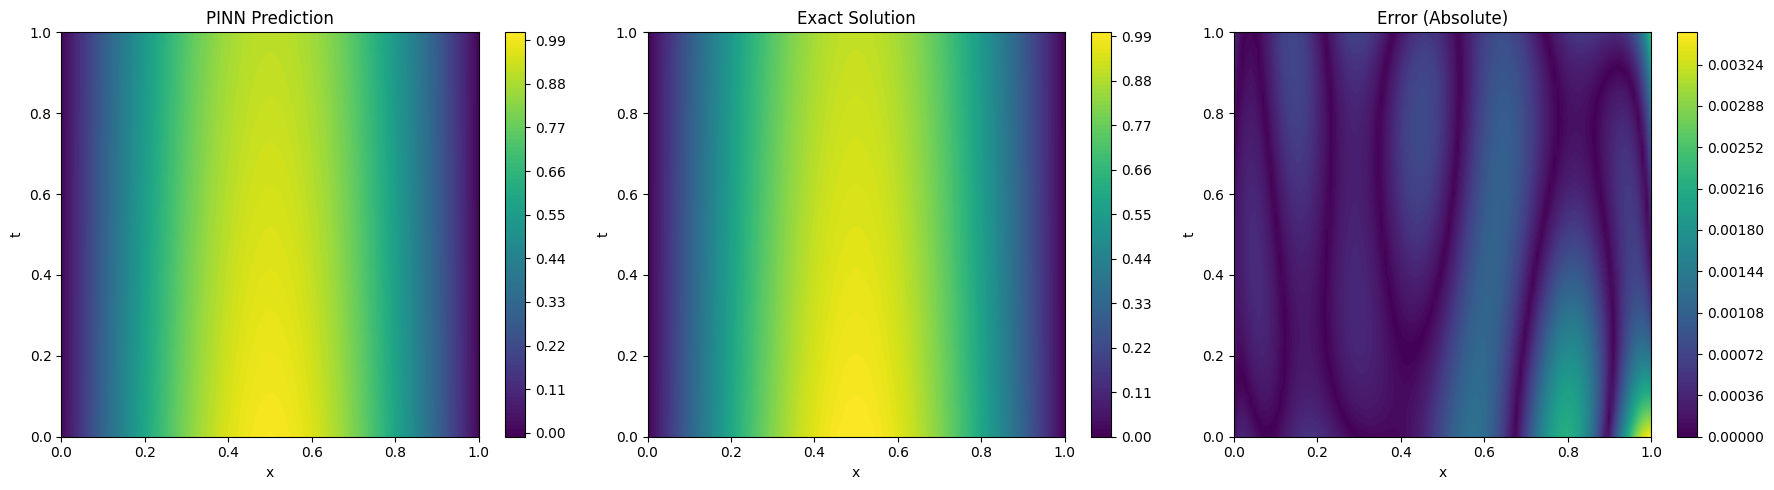

In [7]:
# 7. Prediction and plotting
grid_x = np.linspace(0, 1, 100)
grid_t = np.linspace(0, 1, 100)
X, T = np.meshgrid(grid_x, grid_t)
x_flat = X.flatten()[:, None]
t_flat = T.flatten()[:, None]
x_t_test = tf.convert_to_tensor(np.hstack([x_flat, t_flat]), dtype=tf.float64)
u_pred = model(x_t_test).numpy().reshape(100, 100)

# Exact solution: u(x,t) = exp(-pi^2 * alpha * t) * sin(pi x)
u_exact = np.exp(-np.pi**2 * alpha * T) * np.sin(np.pi * X)

# Compute the error
error = np.abs(u_pred - u_exact)

# Plotting
plt.figure(figsize=(18, 5))

# Plot PINN Prediction
plt.subplot(1, 3, 1)
contour1 = plt.contourf(X, T, u_pred, 100, cmap='viridis')
plt.title('PINN Prediction')
plt.xlabel('x')
plt.ylabel('t')
# Add color bar
plt.colorbar(contour1)

# Plot Exact Solution
plt.subplot(1, 3, 2)
contour2 = plt.contourf(X, T, u_exact, 100, cmap='viridis')
plt.title('Exact Solution')
plt.xlabel('x')
plt.ylabel('t')
# Add color bar
plt.colorbar(contour2)

# Plot Error
plt.subplot(1, 3, 3)
contour3 = plt.contourf(X, T, error, 100, cmap='viridis')
plt.title('Error (Absolute)')
plt.xlabel('x')
plt.ylabel('t')
# Add color bar
plt.colorbar(contour3)

plt.tight_layout()
plt.show()

## **Summary**

- The 1D heat equation was successfully solved using a PINN.

- The network learned to satisfy the PDE and boundary conditions without labeled data for every point.

- This demonstrates the power of combining deep learning with physics.